# Project 2 - INF264
*By Kim Austgulen and Fillip Lampe*

Short overview on this file, this will mainly focus on the results and the basis of what we will write in our report. As we want to keep this file more clean, we have most of the code move into our import files.

In [8]:
import numpy as np

In [9]:
seed = 42
np.random.seed(seed)

In [10]:
dataset = np.load('../data/dataset.npz')
X, y = dataset['X'], dataset['y']

In [11]:
# this will take around 7-8 min depending on the machine
# our SVM model class
from svm import SVM

# it will split the data and preprocess it
n = 5 # number of intervals for the rand search
folds = 3 # number of folds for cross validation

# this will by deafult not use pca
svm = SVM(X, y, n, folds,seed=seed)
svm.fit()
svm_eval_info = svm.evaluate()


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END C=75.55750309950135, coef0=0.009839217559140079, degree=3, gamma=0.0010316674691784767, kernel=rbf, shrinking=True; total time=  18.6s
[CV] END C=75.55750309950135, coef0=0.009839217559140079, degree=3, gamma=0.0010316674691784767, kernel=rbf, shrinking=True; total time=  17.0s
[CV] END C=75.55750309950135, coef0=0.009839217559140079, degree=3, gamma=0.0010316674691784767, kernel=rbf, shrinking=True; total time=  15.9s
[CV] END C=49.54996649841286, coef0=0.1292895346498787, degree=2, gamma=0.03946091208914357, kernel=rbf, shrinking=True; total time=  38.4s
[CV] END C=49.54996649841286, coef0=0.1292895346498787, degree=2, gamma=0.03946091208914357, kernel=rbf, shrinking=True; total time=  37.8s
[CV] END C=49.54996649841286, coef0=0.1292895346498787, degree=2, gamma=0.03946091208914357, kernel=rbf, shrinking=True; total time=  33.9s
[CV] END C=16.99268627803484, coef0=0.009839217559140079, degree=3, gamma=0.058684927748

In [12]:
# Our CNN models (PyTorch)
from pytorch_cnn import CNN_PT

#params must not be changed if you are gonna load the model
n = 5 # number of intervals for the rand search
folds = 3 # number of folds for cross validation
epochs = 10 # number of epochs for training
batch_size = 32 # batch size for training
path = '../other/' # path to save the models

# fit is removed as it is not reproducable
lenet_cnn_pt = CNN_PT(X, y, folds, seed, epochs, batch_size, path, model='lenet')
#lenet_cnn_pt.fit()
lenet_eval_info = lenet_cnn_pt.evaluate(load=True)

# fit is removed as it is not reproducable
alexnet_cnn_pt = CNN_PT(X, y, folds, seed, epochs, batch_size, path, model='alexnet')
#alexnet_cnn_pt.fit()
alexnet_eval_info = alexnet_cnn_pt.evaluate(load=True)


Evaluating model on validation data...
Average loss: 0.0037, Accuracy: 0.9593
Evaluating model on validation data...
Average loss: 0.0033, Accuracy: 0.9559


In [13]:
# Our CNN models (Keras)
# kim will cook up some code here

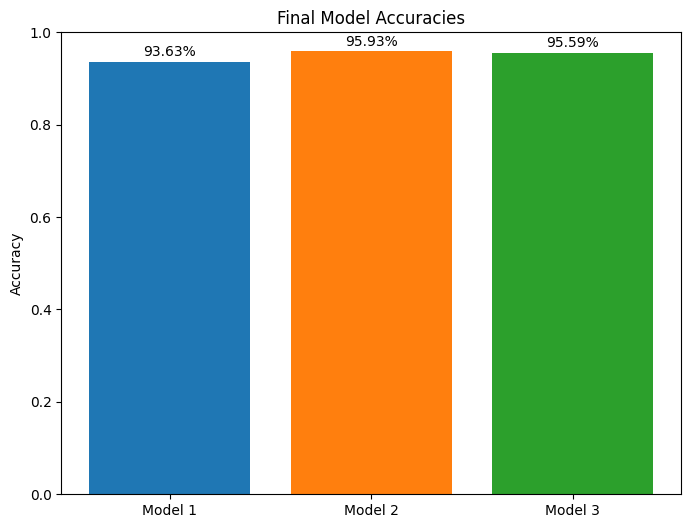

In [14]:
from visiualising import compare_model_accuracy

compare_model_accuracy(svm_eval_info[1], lenet_eval_info[1], alexnet_eval_info[1])